In [3]:
# Load predictive model weights

import pickle

bsnip_mod = pickle.load(open('/home/anton/Documents/Tulane/Research/AngleBasis/data-orig/bsnip_gen_model.pkl', 'rb'))

print(list(bsnip_mod.keys()))

['age', 'sex', 'race', 'sz']


In [92]:
# Load example subjects

import numpy as np

demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'
demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))
fc = []

for sub in demo['Age_cal']:
    fc.append(np.load(f'{demodir}/fc/{sub}_task-unk_fc.npy'))
    
fc = np.stack(fc)
print(fc.shape)

(1244, 34716)


In [8]:
bsnip_mod['age'][0].intercept_

52.44411212143116

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import randint

def rmse(yt, yhat):
    return torch.mean((yt-yhat)**2)**0.5

class Gen(nn.Module):
    def __init__(self, mage, msex, mrace, msz):
        super(Gen, self).__init__()
        self.wage = []
        self.bage = []
        self.wsex = []
        self.bsex = []
        self.wrace = []
        self.brace = []
        self.wsz = []
        self.bsz = []
        for mod in mage:
            self.wage.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.bage.append(torch.Tensor([mod.intercept_]).float().cuda())
        for mod in msex:
            self.wsex.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.bsex.append(torch.from_numpy(mod.intercept_).float().cuda())
        for mod in mrace:
            self.wrace.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.brace.append(torch.from_numpy(mod.intercept_).float().cuda())
        for mod in msz:
            self.wsz.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.bsz.append(torch.from_numpy(mod.intercept_).float().cuda())
#         self.jitter = nn.Parameter((1/(3*264)**0.5)*torch.randn(264,3).float().cuda())
        self.jitter = nn.Parameter(0.5+0.1*torch.randn(264,3).float().cuda())    
        self.thetas = nn.Parameter(3.14+0.1*torch.randn(3,264).float().cuda())
        
    def project(self):
        with torch.no_grad():
            self.jitter[self.jitter < 0] = 0 
            self.jitter[self.jitter > 1] = 1 
        
    def fcimg(self):
        t0 = self.thetas.unsqueeze(2)
        t1 = self.thetas.unsqueeze(1)
        m = torch.einsum('ab,cb->bac',self.jitter,self.jitter)
        return torch.mean(m*torch.cos(t0-t1), axis=0)
#         return self.jitter@self.jitter.T
    
    def fc(self):
        a,b = torch.triu_indices(264,264,offset=1)
        return self.fcimg()[a,b]
    
    def predict(self, age, sex, race, sz):
        aerr = []
        serr = []
        rerr = []
        zerr = []
        efc = self.fc()
        for w,b in zip(self.wage, self.bage):
            aerr.append(rmse(age, w@efc+b))
        for w,b in zip(self.wsex, self.bsex):
            serr.append(torch.abs(sex-w@efc+b))
        for w,b in zip(self.wrace, self.brace):
            rerr.append(torch.abs(race-w@efc+b))
        for w,b in zip(self.wsz, self.bsz):
            zerr.append(torch.abs(sz-w@efc+b))
        return sum(aerr)/len(aerr), sum(serr)/len(serr), sum(rerr)/len(rerr), sum(zerr)/len(zerr)
    
nepochs = 200
pperiod = 100

subj1 = []
subj2 = []

mage = bsnip_mod['age']
msex = bsnip_mod['sex']
mrace = bsnip_mod['race']
msz = bsnip_mod['sz']

for n in range(10):
    gen = Gen(mage, msex, mrace, msz)
    optim = torch.optim.Adam(gen.parameters(), lr=1e-2, weight_decay=0)
    rand_idx = randint(0, fc.shape[0]-1)
    template = torch.from_numpy(fc[rand_idx]).float().cuda()

    for epoch in range(nepochs):
        optim.zero_grad()

        fcloss = torch.sum(F.relu(torch.abs(gen.fc())-1))
        reconloss = rmse(gen.fc(), template)

        aloss, sloss, rloss, zloss = gen.predict(30, -10, -10, -10)
        (fcloss+aloss+sloss+rloss+zloss+200*reconloss).backward()

        optim.step()
        gen.project()
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} {float(reconloss)} {float(fcloss)} {float(aloss)} {float(sloss)} {float(rloss)} {float(zloss)}')
            
    subj1.append(gen.fcimg().detach().cpu().numpy())
    
for n in range(10):
    gen = Gen(mage, msex, mrace, msz)
    optim = torch.optim.Adam(gen.parameters(), lr=1e-2, weight_decay=0)
    rand_idx = randint(0, fc.shape[0]-1)
    template = torch.from_numpy(fc[rand_idx]).float().cuda()

    for epoch in range(nepochs):
        optim.zero_grad()

        fcloss = torch.sum(F.relu(torch.abs(gen.fc())-1))
        reconloss = rmse(gen.fc(), template)

        aloss, sloss, rloss, zloss = gen.predict(30, 10, 10, 10)
        (fcloss+aloss+sloss+rloss+zloss+200*reconloss).backward()

        optim.step()
        gen.project()
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} {float(reconloss)} {float(fcloss)} {float(aloss)} {float(sloss)} {float(rloss)} {float(zloss)}')
            
    subj2.append(gen.fcimg().detach().cpu().numpy())

0 0.27545279264450073 0.0 19.383642196655273 14.696174621582031 11.362805366516113 11.469714164733887
100 0.2614499032497406 0.0 0.1544763594865799 2.3554704189300537 1.9516085386276245 1.3421273231506348
199 0.24782738089561462 0.0 0.10820579528808594 1.1310417652130127 0.9763342142105103 0.6305627226829529
0 0.2694282829761505 0.0 19.951997756958008 15.395766258239746 10.260589599609375 11.541954040527344
100 0.24072159826755524 0.0 0.3710750639438629 1.8743717670440674 1.6304502487182617 0.8336256146430969
199 0.2151116281747818 0.0 0.5627832412719727 0.7994982600212097 0.6986364722251892 0.6803097128868103
0 0.17865173518657684 0.0 16.710840225219727 14.885275840759277 10.995318412780762 11.449881553649902
100 0.17680372297763824 0.0 0.26548710465431213 3.097001791000366 1.6274133920669556 1.1950844526290894
199 0.15767718851566315 0.0 0.16055850684642792 2.446676731109619 1.0472825765609741 0.9166523814201355
0 0.18416361510753632 0.0 17.861318588256836 15.180719375610352 10.87848

In [11]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


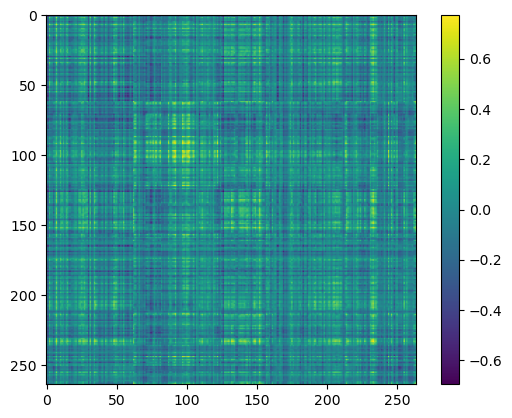

In [116]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(remap(np.mean(np.stack(subj1), axis=0)-np.mean(np.stack(subj2), axis=0)))
# plt.imshow(remap(subj1[8]))
plt.colorbar()
plt.show()